In [731]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
import mxnet as mx
import logging
from sklearn.metrics import accuracy_score

In [732]:
NUM_NODE = 100
WEIGHT_MIN = .0
WEIGHT_MAX = 1.
OUT_DEGREE_MAX = 10

In [733]:
def generate_low_degree_g(node_size=20, min_out_degree=2, max_out_degree=4, weight_min=WEIGHT_MIN, weight_max=WEIGHT_MAX):
    
    G = nx.DiGraph()
    G.add_nodes_from(range(0, node_size))
    
    for node in G.nodes:
        tmp_nodes = list(G.nodes)
        tmp_nodes.remove(node)
        random.shuffle(tmp_nodes)
        
        out_neighbors = tmp_nodes[:random.randint(min_out_degree, max_out_degree)]
        
#         print(node, out_neighbors)
        
#         G.add_edges_from(map(lambda d:(node, d), out_neighbors))
        
        for out_neighbor in out_neighbors:
            G.add_edge(node, out_neighbor, weight=random.uniform(weight_min, weight_max))
        
    return G

def generate_rand_weighted_g(node_size=NUM_NODE, p=0.02, directed=True, weight_min=WEIGHT_MIN, weight_max=WEIGHT_MAX):

    rnd_g = nx.erdos_renyi_graph(node_size, p, directed=directed)

    for edge in rnd_g.edges(data=True):
        rnd_g.add_edge(edge[0], edge[1], weight=random.uniform(weight_min, weight_max))
        
    return rnd_g

def print_g(G):
    for edge in G.edges(data=True):
        print(edge)

In [874]:
G = generate_rand_weighted_g(node_size=NUM_NODE, p=0.06)
print(G.number_of_nodes())
print(G.number_of_edges())
max_out_degree = max(G.out_degree, key=lambda d: d[1])[1]
max_out_degree

100
609


12

In [915]:
G = generate_low_degree_g()
print(G.number_of_nodes())
print(G.number_of_edges())

20
68


In [917]:
nx.find_cycle(G)

[(0, 17), (17, 10), (10, 0)]

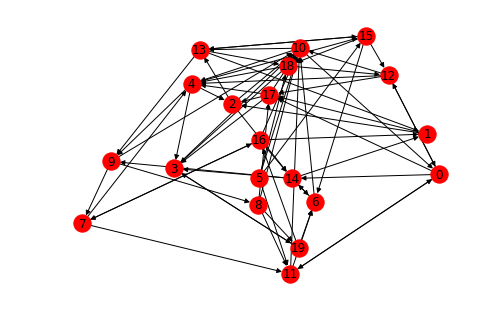

In [918]:
nx.draw(G, with_labels=True)
plt.show()

In [919]:
max_out_degree = max(G.out_degree, key=lambda d: d[1])[1]
max_out_degree

4

In [920]:
def one_hot_encode(idx, length=max_out_degree):
    
    ret = np.zeros(length)
    ret[idx] = 1.0
    return ret

def generate_dataset(G):
    
    X, y = [], []
    
    for node in G.nodes:

        if G.out_degree(node) == 0:
            print('Node %d has 0 out degree' % node)
            continue

        init_weight_vec = np.ones(max_out_degree)

        for idx, out_edge in enumerate(G.out_edges(node)):
            init_weight_vec[idx] = G.get_edge_data(node, out_edge[1])['weight']

        out_neighbors = map(lambda t: (t[1], G.get_edge_data(node, t[1])['weight']),  G.out_edges(node))
    #     print(node, min(out_neighbors, key=lambda d: d[1]), len(out_neighbors), sorted(out_neighbors))

    #     label = one_hot_encode(np.argmin(init_weight_vec, axis=0))
        label = min(out_neighbors, key=lambda d: d[1])[1]
    #     print(label, init_weight_vec[np.argmin(init_weight_vec)])
        assert label == init_weight_vec[np.argmin(init_weight_vec)]
        X.append(init_weight_vec)
        y.append(label)
    
    return np.array(X), np.array(y)

features, labels = generate_dataset(G)

In [921]:
print(features.shape)
print(labels.shape)

(20, 4)
(20,)


In [922]:
def augment_dataset(X, y=None, augmentation_index=10):
    
    X_aug, y_aug = [], []
    indices = np.arange(len(X[0]))
    
    for idx, x in enumerate(X):
        for _ in range(augmentation_index):
            np.random.shuffle(indices)
            
            X_aug.append(x[indices])
            y_aug.append(one_hot_encode(np.argmin(x[indices])))
            
    return np.array(X_aug), np.array(y_aug)

def augment_dataset_extend_features(X, y=None, augmentation_index=10):
    pass

In [924]:
X_aug, y_aug = augment_dataset(features, labels, augmentation_index=100)
print(X_aug.shape)
print(y_aug.shape)

(2000, 4)
(2000, 4)


In [925]:
print(X_aug[0])
print(y_aug[0])

[ 0.25297004  0.30496655  0.62963934  0.08270936]
[ 0.  0.  0.  1.]


In [926]:
indices = np.arange(len(X_aug))
np.random.shuffle(indices)
X, y =  X_aug[indices], y_aug[indices]
print(X.shape)
print(y.shape)

(2000, 4)
(2000, 4)


In [927]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1800, 4)
(1800, 4)
(200, 4)
(200, 4)


In [991]:
batch_size = 100

train_iter = mx.io.NDArrayIter(X_train, y_train, batch_size, shuffle=True)
val_iter = mx.io.NDArrayIter(X_test, y_test, batch_size=len(y_test))

In [992]:
def build_model(context=mx.gpu()):
    
    data = mx.sym.var('data')
    label = mx.sym.var('softmax_label')
    
    fc2  = mx.sym.FullyConnected(data=data, num_hidden=32)
    fc2 = mx.sym.Activation(data=fc2, act_type="relu")
    
    fc3  = mx.sym.FullyConnected(data=fc2, num_hidden=max_out_degree)
    mlp  = mx.sym.SoftmaxOutput(data=fc3, label=label)
    
    return mx.mod.Module(symbol=mlp, context=context)

In [993]:
logging.getLogger().setLevel(logging.DEBUG)  # logging to stdout
model = build_model()
model.bind(data_shapes=train_iter.provide_data, label_shapes=train_iter.provide_label)
model.init_params()

In [994]:
def custom_acc(label, pred):
    tmp_label = np.argmax(label, axis=1)
    tmp_pred = np.argmax(pred, axis=1)
    return accuracy_score(tmp_label, tmp_pred)

custom_metric = mx.metric.create(custom_acc)

In [995]:
model.fit(train_iter,  # train data
              eval_data=val_iter,  # validation data
              optimizer='adam',  # use SGD to train
#               optimizer_params={'learning_rate':0.01, 'momentum': 0.9},
              eval_metric=custom_metric,  # report accuracy during training
              batch_end_callback = mx.callback.Speedometer(batch_size, 10), # output progress for each 100 data batches
              num_epoch=40)  # train for at most 10 dataset passes

INFO:root:Epoch[0] Batch [10]	Speed: 69347.97 samples/sec	custom_acc=0.279091
INFO:root:Epoch[0] Train-custom_acc=0.537143
INFO:root:Epoch[0] Time cost=0.033
INFO:root:Epoch[0] Validation-custom_acc=0.620000
INFO:root:Epoch[1] Batch [10]	Speed: 55169.34 samples/sec	custom_acc=0.667273
INFO:root:Epoch[1] Train-custom_acc=0.731429
INFO:root:Epoch[1] Time cost=0.037
INFO:root:Epoch[1] Validation-custom_acc=0.640000
INFO:root:Epoch[2] Batch [10]	Speed: 73029.51 samples/sec	custom_acc=0.756364
INFO:root:Epoch[2] Train-custom_acc=0.818571
INFO:root:Epoch[2] Time cost=0.031
INFO:root:Epoch[2] Validation-custom_acc=0.760000
INFO:root:Epoch[3] Batch [10]	Speed: 52579.31 samples/sec	custom_acc=0.845455
INFO:root:Epoch[3] Train-custom_acc=0.898571
INFO:root:Epoch[3] Time cost=0.044
INFO:root:Epoch[3] Validation-custom_acc=0.905000
INFO:root:Epoch[4] Batch [10]	Speed: 66970.64 samples/sec	custom_acc=0.918182
INFO:root:Epoch[4] Train-custom_acc=0.945714
INFO:root:Epoch[4] Time cost=0.032
INFO:root:

INFO:root:Epoch[38] Time cost=0.022
INFO:root:Epoch[38] Validation-custom_acc=0.980000
INFO:root:Epoch[39] Batch [10]	Speed: 105554.26 samples/sec	custom_acc=0.988182
INFO:root:Epoch[39] Train-custom_acc=0.987143
INFO:root:Epoch[39] Time cost=0.022
INFO:root:Epoch[39] Validation-custom_acc=0.980000


In [1065]:
pred = np.argmax(model.predict(mx.io.NDArrayIter(X_train, y_train, batch_size=len(y_train))).asnumpy(), axis=1)
accuracy_score(np.argmax(y_train, axis=1), pred)

0.98833333333333329

In [1031]:
def infer_next_node(G, cur_node):
    return min(map(lambda t: (t[1], G.get_edge_data(cur_node, t[1])['weight']),  G.out_edges(cur_node)), key=lambda d:d[1])

def nn_infer_next_node(G, cur_node, model):
    
    input_vec = np.ones(4)
    
    for idx, out_edge in enumerate(G.out_edges(cur_node)):
        input_vec[idx] = G.get_edge_data(cur_node, out_edge[1])['weight']
    
    
    out_neighbors = map(lambda t: (t[1], G.get_edge_data(cur_node, t[1])['weight']),  G.out_edges(cur_node))
    
    pred_idx = np.argmax(model.predict(mx.io.NDArrayIter(np.array([input_vec]), np.array([0]))).asnumpy()[0])
    return out_neighbors[pred_idx]

def greedy_path_finder(G, src, dst, use_nn=False, model=None):
    
    path = [src]
    cur_node = src
    total_weights = .0
    
    while True:
        
        if len(path) >= G.number_of_nodes():
            return path, total_weights, False
        
        next_node, weight = nn_infer_next_node(G, cur_node, model) if use_nn else infer_next_node(G, cur_node)
        total_weights += weight
        path.append(next_node)
        
        if next_node == dst:
            return path, total_weights, True
        
        cur_node = next_node

In [1067]:
src, dst = 8, 17

print greedy_path_finder(G, src, dst)
print greedy_path_finder(G, src, dst, use_nn=True, model=model)

([8, 10, 4, 3, 19, 16, 1, 17], 1.6425328727856368, True)
([8, 10, 4, 3, 19, 16, 1, 17], 1.6425328727856368, True)


In [1069]:
nx.dijkstra_path(G, 8, 17)

[8, 10, 13, 1, 17]

In [1063]:
def check_greedy_path_finder_acc(G, model):
    
    correct_cnt = 0
    
    for src in G.nodes:
        for dst in G.nodes:
            
            if src == dst:
                continue
            
            path, _, found = greedy_path_finder(G, src, dst)
            nn_path, _, nn_found = greedy_path_finder(G, src, dst, use_nn=True, model=model)
            
            if found == nn_found and path == nn_path:
                correct_cnt = correct_cnt + 1
            else:
                print('src %d dst %d incorrect' % (src, dst))
    
    num_nodes = G.number_of_nodes()
    return float(correct_cnt) / (num_nodes*(num_nodes-1))

In [1064]:
check_greedy_path_finder_acc(G, model)

1.0

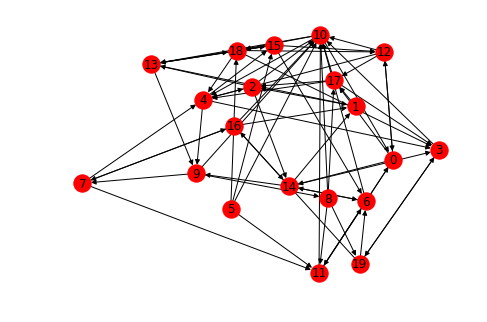

In [1024]:
nx.draw(G, with_labels=True)
plt.show()

# Some take-ways from this notebook

Greedy strategy can be perfectly and easily approximated by a neural network;
However, greedy strategy itself isn't good enough compared to Dijkstra; the 
algorithm can easily be stuck in a cycle, leading to bad results.

It would be very interesting to see to what extent can Dijkstra be approximated.